# Importing libraries

In [1]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5


In [2]:
# Install required dependencies
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 37.6 MB/s eta 0:00:00


# Unified Model Architecture

Input Image
   → Pretrained YOLO (Feature Extraction + Bounding Box Predictions)
      → ROI Pooling Layer (Extract Features for Each Bounding Box)
         → Classifier Head (Fine-tuned VGG16 or Custom CNN for Defect Classification)
            → Combined Output (Bounding Boxes + Defect Labels)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Loding dataset

In [ ]:
import zipfile

# Path to the uploaded file
zip_file_path = '/content/train.zip'

# Path to extract the contents
extract_path = '/content/train'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /content/train


In [ ]:
import zipfile

# Path to the uploaded file
zip_file_path = '/content/test.zip'

# Path to extract the contents
extract_path = '/content/test'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /content/test


In [ ]:
import os
import tensorflow as tf

# Dataset loader with robustness
def load_dataset(image_dir, label_dir, target_size=(640, 640)):
    images = []
    bboxes = []
    labels = []
    missing_labels = []
    corrupt_labels = []

    for img_file in os.listdir(image_dir):
        try:
            # Load image
            img_path = os.path.join(image_dir, img_file)
            image = tf.io.read_file(img_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, target_size) / 255.0  # Normalize to [0, 1]

            # Load corresponding label
            label_file = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))
            if not os.path.exists(label_file):
                missing_labels.append(img_file)
                continue  # Skip if label file is missing

            with open(label_file, 'r') as f:
                label_data = f.readlines()

            bbox = []
            class_ids = []
            for line in label_data:
                try:
                    # Parse YOLO label format
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    class_ids.append(int(class_id))

                    # Convert YOLO format to [x_min, y_min, x_max, y_max]
                    x_min = (x_center - width / 2) * target_size[0]
                    y_min = (y_center - height / 2) * target_size[1]
                    x_max = (x_center + width / 2) * target_size[0]
                    y_max = (y_center + height / 2) * target_size[1]
                    bbox.append([x_min, y_min, x_max, y_max])
                except ValueError:
                    corrupt_labels.append(label_file)
                    break  # Skip this image if label parsing fails

            if bbox:  # Add only if bounding boxes are valid
                images.append(image)
                bboxes.append(bbox)
                labels.append(class_ids)
        except Exception as e:
            print(f"Error processing file {img_file}: {e}")

    if missing_labels:
        print(f"Missing labels for {len(missing_labels)} images.")
    if corrupt_labels:
        print(f"Corrupt labels in {len(corrupt_labels)} files.")

    return images, bboxes, labels

# Paths to train/test folders
train_image_dir = '/content/drive/MyDrive/Building_Defects/Dataset/train/images'
train_label_dir = '/content/drive/MyDrive/Building_Defects/Dataset/train/labels'
test_image_dir = '/content/drive/MyDrive/Building_Defects/Dataset/test/images'
test_label_dir = '/content/drive/MyDrive/Building_Defects/Dataset/test/labels'

# Load train and test datasets
train_images, train_bboxes, train_labels = load_dataset(train_image_dir, train_label_dir)
test_images, test_bboxes, test_labels = load_dataset(test_image_dir, test_label_dir)

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images.")


Missing labels for 143 images.
Missing labels for 143 images.
Loaded 573 training images and 37 test images.


In [ ]:
import shutil
import os
from sklearn.model_selection import train_test_split

# Paths for train and test datasets
train_images_path = "/content/drive/MyDrive/Building_Defects/train/images"
train_labels_path = "/content/drive/MyDrive/Building_Defects/train/labels"
test_images_path = "/content/drive/MyDrive/Building_Defect/test/images"
test_labels_path = "/content/drive/MyDrive/Building_Defects/test/labels"

combined_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/combined/images"
combined_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/combined/labels"
"""
# Paths for train and test datasets
train_images_path = "/content/Dataset/train/images"
train_labels_path = "/content/Dataset/train/labels"
test_images_path = "/content/Dataset/test/images"
test_labels_path = "/content/Dataset/test/labels"

combined_images_path = "/content/Dataset/combined/images"
combined_labels_path = "/content/Dataset/combined/labels"
"""

# Create output directories if they don't exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)

# Combine all image and label files into one list
all_images = os.listdir(combined_images_path)
all_labels = os.listdir(combined_labels_path)

In [ ]:
import os
import shutil

# Define your source and destination paths for train and test datasets
train_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/train/images"
train_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/train/labels"
test_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/test/images"
test_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/test/labels"


## Preparing Dataset pipeline

In [ ]:
def create_tf_dataset(images, bboxes, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, bboxes, labels))
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create train and test datasets
batch_size = 16
train_dataset = create_tf_dataset(train_images, train_bboxes, train_labels, batch_size)
test_dataset = create_tf_dataset(test_images, test_bboxes, test_labels, batch_size)


In [ ]:
def yolo_loss(pred_bboxes, true_bboxes):
    # Replace this with a custom YOLO loss function
    return tf.reduce_mean(tf.square(pred_bboxes - true_bboxes))

def classifier_loss(pred_labels, true_labels):
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(true_labels, pred_labels)

def combined_loss(bbox_loss, label_loss, alpha=1.0, beta=1.0):
    return alpha * bbox_loss + beta * label_loss


# Define the YOLO + Classifier Model

In [ ]:
import tensorflow as tf
from ultralytics import YOLO
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

# Load pretrained YOLO model
yolo_model = YOLO('yolov5s.pt')  # Pretrained YOLOv8 weights

def yolo_backbone(image):
    """
    Use YOLO as a feature extractor and bounding box predictor.
    """
    results = yolo_model(image)  # Forward pass through YOLO
    bboxes = results[0].boxes.xyxy  # Extract bounding boxes
    features = results[0].features  # Feature map from YOLO
    return features, bboxes

# Define the Classifier Head (e.g., VGG16 or Custom CNN)
def build_classifier(input_shape=(7, 7, 512), num_classes=4):
    """
    Build the classifier head for defect classification.
    """
    base_model = tf.keras.applications.VGG16(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global pooling for feature reduction
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    output = Dense(num_classes, activation='softmax')(x)  # Output layer
    return Model(inputs=base_model.input, outputs=output)

# Build the Unified Model
class YOLOWithClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super(YOLOWithClassifier, self).__init__()
        self.yolo = yolo_model
        self.classifier = build_classifier(num_classes=num_classes)

    def call(self, inputs):
        # YOLO for feature extraction and bounding box prediction
        features, bboxes = yolo_backbone(inputs)

        # ROI pooling: Use bounding boxes to extract features
        rois = self.roi_pooling(features, bboxes)

        # Classification head
        predictions = self.classifier(rois)

        return bboxes, predictions

    def roi_pooling(self, features, bboxes):
        """
        ROI pooling implementation for extracting bounding box features.
        """
        pooled_features = []
        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)
            roi = features[:, y1:y2, x1:x2, :]  # Crop the ROI
            roi = tf.image.resize(roi, (7, 7))  # Resize to match classifier input
            pooled_features.append(roi)
        return tf.stack(pooled_features)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 24.7MB/s]


In [ ]:
def yolo_loss(pred_bboxes, true_bboxes):
    """
    Compute YOLO bounding box loss (e.g., MSE for regression).
    """
    return tf.reduce_mean(tf.square(pred_bboxes - true_bboxes))

def classifier_loss(pred_labels, true_labels):
    """
    Compute classification loss (e.g., Categorical Crossentropy).
    """
    return tf.keras.losses.categorical_crossentropy(true_labels, pred_labels)

def combined_loss(yolo_loss_value, classifier_loss_value, alpha=1.0, beta=1.0):
    """
    Combine YOLO and classifier loss with weights alpha and beta.
    """
    return alpha * yolo_loss_value + beta * classifier_loss_value


In [13]:
# Paths
# Define your pathsPorosity Overweld
categories = [ 'Porosity','Overweld','Underfilled', 'Undercut']
label_map = {0: 'Porosity', 1: 'Overweld', 2: 'Underfilled', 3: 'Undercut'}

In [ ]:
import zipfile

# Path to the uploaded file
zip_file_path = '/content/drive/MyDrive/Dataset-20250102T092628Z-001.zip'

# Path to extract the contents
extract_path = '/content'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")


Files extracted to /content


In [ ]:
import zipfile

# Path to the uploaded file
zip_file_path = '/content/test.zip'

# Path to extract the contents
extract_path = '/content/test'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /content/test


In [ ]:
"""
# Now you can download the zip files
from google.colab import files
files.download('/content/augmented_images_labels.zip')
files.download('/content/augmented_labels.zip')"""

"\n# Now you can download the zip files\nfrom google.colab import files\nfiles.download('/content/augmented_images_labels.zip')\nfiles.download('/content/augmented_labels.zip')"

In [13]:
import cv2
import os
import albumentations as A

# Paths
input_images_path = "/content/drive/MyDrive/Defects_welding/yolo/original/images"
input_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/original/labels"
output_images_path = "/content/drive/MyDrive/Defects_welding/yolo/Agu/images"
output_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/Agu/labels"

# Create output directories if they don't exist
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)

# Augmentation pipeline
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=15, p=0.4),
        A.RandomBrightnessContrast(p=0.4),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]),
)

# Target number of images for each category
target_images_per_category = {
    0: 500,  # overweld
    1: 500,  # porosity
    2: 500,  # undercut
    3: 500,  # underfilled
}

# List all image files in the images folder
image_files = [f for f in os.listdir(input_images_path) if f.endswith('.jpg')]

# Function to get the category of an image from its label file
def get_category_from_label(label_path):
    with open(label_path, "r") as f:
        class_id = int(f.readline().split()[0])  # First entry in label corresponds to the class
    return class_id

# Organize images by category
images_by_category = {0: [], 1: [], 2: [], 3: []}
for img_file in image_files:
    img_path = os.path.join(input_images_path, img_file)
    label_path = os.path.join(input_labels_path, img_file.replace(".jpg", ".txt"))

    # Get the category for the image
    category = get_category_from_label(label_path)

    # Add the image to the appropriate category list
    images_by_category[category].append(img_file)

# Process each category and augment images to meet the target
for category, image_list in images_by_category.items():
    category_name = categories[category]
    current_image_count = len(image_list)
    target_count = target_images_per_category[category]
    augmentations_needed = target_count - current_image_count

    print(f"Processing category: {category_name} | Current: {current_image_count}, Target: {target_count}, Needed: {augmentations_needed}")

    if augmentations_needed > 0:
        for img_file in image_list:
            img_path = os.path.join(input_images_path, img_file)
            image = cv2.imread(img_path)

            label_path = os.path.join(input_labels_path, img_file.replace(".jpg", ".txt"))
            with open(label_path, "r") as f:
                bboxes = []
                class_labels = []
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    bboxes.append([x_center, y_center, width, height])
                    class_labels.append(class_id)

            # Generate the required number of augmentations
            for i in range(augmentations_needed):
                augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                augmented_image = augmented["image"]
                augmented_bboxes = augmented["bboxes"]

                # Save augmented image
                aug_img_name = f"aug_{category}_{i}_{img_file}"
                cv2.imwrite(os.path.join(output_images_path, aug_img_name), augmented_image)

                # Save augmented labels
                aug_label_name = f"aug_{category}_{i}_{img_file.replace('.jpg', '.txt')}"
                with open(os.path.join(output_labels_path, aug_label_name), "w") as f:
                    for bbox, class_id in zip(augmented_bboxes, class_labels):
                        f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

                augmentations_needed -= 1
                if augmentations_needed == 0:
                    break
    else:
        print(f"Category '{category_name}' already meets or exceeds the target count. No augmentation needed.")

print("Augmentation completed!")


Processing category: Porosity | Current: 32, Target: 500, Needed: 468
Processing category: Overweld | Current: 41, Target: 500, Needed: 459
Processing category: Underfilled | Current: 45, Target: 500, Needed: 455
Processing category: Undercut | Current: 45, Target: 500, Needed: 455
Augmentation completed!


In [8]:
import os

label_path = "/content/drive/MyDrive/Defects_welding/yolo/original/labels/WhatsApp Image 2024-05-16 at 07.32.53_b529942f.txt"
print(os.path.exists(label_path))


False


In [ ]:
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 16.8 MB/s eta 0:00:00


In [14]:
# Function to count images in each category
def count_images_by_category(images_by_category, input_labels_path):
    category_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for category, image_list in images_by_category.items():
        category_counts[category] = len(image_list)
    return category_counts

# Print initial counts
initial_counts = count_images_by_category(images_by_category, input_labels_path)
print("Initial Counts Per Category:")
for category, count in initial_counts.items():
    print(f"Category {categories[category]} ({category}): {count} images")

# Augmentation process (no changes to previous code here)

# Count images again after augmentation
final_images_by_category = {0: [], 1: [], 2: [], 3: []}
output_image_files = [f for f in os.listdir(output_images_path) if f.endswith('.jpg')]

for img_file in output_image_files:
    label_path = os.path.join(output_labels_path, img_file.replace(".jpg", ".txt"))
    category = get_category_from_label(label_path)
    final_images_by_category[category].append(img_file)

final_counts = count_images_by_category(final_images_by_category, output_labels_path)
print("\nFinal Counts Per Category After Augmentation:")
for category, count in final_counts.items():
    print(f"Category {categories[category]} ({category}): {count} images")


Initial Counts Per Category:
Category Porosity (0): 32 images
Category Overweld (1): 41 images
Category Underfilled (2): 45 images
Category Undercut (3): 45 images

Final Counts Per Category After Augmentation:
Category Porosity (0): 468 images
Category Overweld (1): 459 images
Category Underfilled (2): 455 images
Category Undercut (3): 455 images


In [ ]:
# Function to count total images in all categories
def count_total_images(category_counts):
    return sum(category_counts.values())

# Print initial counts
initial_counts = count_images_by_category(images_by_category, input_labels_path)
initial_total = count_total_images(initial_counts)

print("Initial Counts Per Category:")
for category, count in initial_counts.items():
    print(f"Category {categories[category]} ({category}): {count} images")
print(f"Total images before augmentation: {initial_total}")

# Augmentation process (no changes to previous code here)

# Count images again after augmentation
final_images_by_category = {0: [], 1: [], 2: [], 3: []}
output_image_files = [f for f in os.listdir(output_images_path) if f.endswith('.jpg')]

for img_file in output_image_files:
    label_path = os.path.join(output_labels_path, img_file.replace(".jpg", ".txt"))
    category = get_category_from_label(label_path)
    final_images_by_category[category].append(img_file)

final_counts = count_images_by_category(final_images_by_category, output_labels_path)
final_total = count_total_images(final_counts)

print("\nFinal Counts Per Category After Augmentation:")
for category, count in final_counts.items():
    print(f"Category {categories[category]} ({category}): {count} images")
print(f"Total images after augmentation: {final_total}")


Initial Counts Per Category:
Category overweld (0): 224 images
Category porosity (1): 224 images
Category undercut (2): 224 images
Category underfilled (3): 224 images
Total images before augmentation: 896

Final Counts Per Category After Augmentation:
Category overweld (0): 276 images
Category porosity (1): 276 images
Category undercut (2): 276 images
Category underfilled (3): 276 images
Total images after augmentation: 1104


In [15]:
import os
import shutil
original_images_path = "/content/drive/MyDrive/Defects_welding/yolo/original/images"
original_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/original/labels"
augmented_images_path = "/content/drive/MyDrive/Defects_welding/yolo/Agu/images"
augmented_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/Agu/labels"
"""
original_images_path =  "/content/drive/MyDrive/Building_Defects/Dataset/images"
original_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/labels"
augmented_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/Aaugment_images"
augmented_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/Aaugmented_labels"
"""
combined_images_path = "/content/drive/MyDrive/Defects_welding/yolo/combined/images"
combined_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/combined/labels"

# Create output directories if they don't exist
os.makedirs(combined_images_path, exist_ok=True)
os.makedirs(combined_labels_path, exist_ok=True)

# Function to copy images and labels to the combined folder with a label (original/augmented)
def copy_images_and_labels(images_path, labels_path, destination_images_path, destination_labels_path, label_type):
    image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]  # Adjust image extension if needed

    for image_file in image_files:
        # Copy image file to destination
        src_image_path = os.path.join(images_path, image_file)
        dst_image_path = os.path.join(destination_images_path, f"{label_type}_{image_file}")
        shutil.copy(src_image_path, dst_image_path)

        # Copy corresponding label file to destination
        label_file = image_file.replace(".jpg", ".txt")  # Assuming .txt for label files
        src_label_path = os.path.join(labels_path, label_file)
        dst_label_path = os.path.join(destination_labels_path, f"{label_type}_{label_file}")
        shutil.copy(src_label_path, dst_label_path)

# Copy original images and labels with "original" label
copy_images_and_labels(original_images_path, original_labels_path, combined_images_path, combined_labels_path, "original")

# Copy augmented images and labels with "augmented" label
copy_images_and_labels(augmented_images_path, augmented_labels_path, combined_images_path, combined_labels_path, "augmented")

# Print the number of combined images
combined_image_files = [f for f in os.listdir(combined_images_path) if f.endswith('.jpg')]
print(f"Total images in the combined folder: {len(combined_image_files)}")


Total images in the combined folder: 2000


In [16]:
# Function to calculate the combined total of original and augmented images
def calculate_totals(images_by_category, augmented_labels_path):
    # Initialize a dictionary to store totals for each category
    combined_counts = {0: 0, 1: 0, 2: 0, 3: 0}

    # Count original images
    for category, files in images_by_category.items():
        combined_counts[category] += len(files)

    # Count augmented images
    augmented_label_files = [f for f in os.listdir(augmented_labels_path) if f.endswith('.txt')]
    for label_file in augmented_label_files:
        label_path = os.path.join(augmented_labels_path, label_file)
        category = get_category_from_label(label_path)
        combined_counts[category] += 1  # Add 1 for each augmented label in the category

    return combined_counts

# Calculate combined totals
combined_counts = calculate_totals(images_by_category, output_labels_path)

# Display combined totals and grand total
print("Combined (Original + Augmented) Counts Per Category:")
grand_total = 0
for category, count in combined_counts.items():
    print(f"Category {categories[category]} ({category}): {count} images")
    grand_total += count

print(f"Grand Total (All Categories): {grand_total} images")

Combined (Original + Augmented) Counts Per Category:
Category Porosity (0): 500 images
Category Overweld (1): 500 images
Category Underfilled (2): 500 images
Category Undercut (3): 500 images
Grand Total (All Categories): 2000 images


In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
combined_images_path = "/content/drive/MyDrive/Defects_welding/yolo/combined/images"
combined_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/combined/labels"

train_images_path = "/content/drive/MyDrive/Defects_welding/yolo/train/images"
train_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/train/labels"
test_images_path = "/content/drive/MyDrive/Defects_welding/yolo/test/images"
test_labels_path = "/content/drive/MyDrive/Defects_welding/yolo/test/labels"

# Ensure destination directories exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)

# Get list of image and label files
image_files = sorted(os.listdir(combined_images_path))
label_files = sorted(os.listdir(combined_labels_path))

# Ensure each image has a corresponding label
image_files = [img for img in image_files if os.path.splitext(img)[0] + ".txt" in label_files]
label_files = [lbl for lbl in label_files if os.path.splitext(lbl)[0] + ".jpg" in image_files]

# Perform an 80-20 split
train_images, test_images, train_labels, test_labels = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42
)

# Function to move files
def move_files(file_list, source_folder, destination_folder):
    for file_name in file_list:
        shutil.copy(os.path.join(source_folder, file_name), os.path.join(destination_folder, file_name))

# Move training data
move_files(train_images, combined_images_path, train_images_path)
move_files(train_labels, combined_labels_path, train_labels_path)

# Move testing data
move_files(test_images, combined_images_path, test_images_path)
move_files(test_labels, combined_labels_path, test_labels_path)

print("Dataset successfully split and saved!")

Dataset successfully split and saved!


# Model training

In [3]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17274, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17274 (delta 1), reused 0 (delta 0), pack-reused 17270 (from 3)
Receiving objects: 100% (17274/17274), 16.13 MiB | 28.68 MiB/s, done.
Resolving deltas: 100% (11859/11859), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 17.3 MB/s eta 0:00:00a 0:00:01


In [13]:
import yaml

data = {
    'train': '/kaggle/input/data-welding/train-20250312T172148Z-001/train/images',
    'val': '/kaggle/input/data-welding/test-20250312T172147Z-001/test/images',
    'test': '/kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images',
    'nc': 4,
    'names': ['Porosity', 'Overweld', 'Underfilled', 'Undercut']
}

with open('/kaggle/working/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=None)


In [24]:
import yaml

data = {
    'path': '/content/drive/MyDrive/Defects_welding/yolo/',
    'train': 'train/images',
    'val': 'test/images',
    'nc': 4,
    'names': ['Porosity', 'Overweld', 'Underfilled', 'Undercut']
}

with open('/content/drive/MyDrive/Defects_welding/yolo/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=None)


## YOLOv8s

In [25]:
from ultralytics import YOLO
import torch

# Path to your dataset's YAML file
data_yaml_path = '/content/drive/MyDrive/Defects_welding/yolo/data.yaml'  # Ensure this YAML file is correctly configured

# Load YOLOv8 model with pre-trained weights
model = YOLO("yolov8s.pt")  # Using YOLOv8 weights

# Train the model
model.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 163MB/s] 


Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Defects_welding/yolo/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 25.8MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 90.6MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Defects_welding/yolo/train/labels... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:26<00:00, 61.49it/s] 


train: New cache created: /content/drive/MyDrive/Defects_welding/yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Defects_welding/yolo/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:05<00:00, 69.51it/s] 


val: New cache created: /content/drive/MyDrive/Defects_welding/yolo/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.54G       1.57       1.96      1.721         38        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]

                   all        400        405      0.791      0.576      0.758      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.67G     0.9517     0.7247      1.243         31        640: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]

                   all        400        405      0.974      0.908      0.941      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.68G     0.8284     0.6184      1.162         20        640: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]

                   all        400        405      0.985      0.923      0.965      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.68G     0.7446     0.5709      1.131         24        640: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


                   all        400        405       0.99      0.914      0.953      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.68G      0.654     0.5077      1.056         32        640: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all        400        405      0.993      0.886      0.955      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.68G     0.5932      0.446       1.03         35        640: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]

                   all        400        405      0.993      0.918       0.97      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.68G     0.5891     0.4221      1.024         27        640: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


                   all        400        405      0.985      0.934      0.969      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.68G     0.5457     0.4098      1.011         31        640: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]

                   all        400        405      0.993      0.917      0.967      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.68G     0.4965     0.3858     0.9895         28        640: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]

                   all        400        405      0.973      0.942      0.976      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.68G     0.4718     0.3475     0.9635         33        640: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


                   all        400        405      0.988      0.925      0.974      0.902
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.68G     0.4031     0.3015     0.9532         16        640: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all        400        405      0.983      0.933      0.973      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.68G     0.3787     0.2785     0.9325         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

                   all        400        405      0.995      0.916      0.974      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.68G     0.3513      0.269     0.9144         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]

                   all        400        405       0.98      0.938      0.981      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.68G     0.3265     0.2506     0.9003         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]

                   all        400        405      0.994      0.925      0.975      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.68G     0.3115     0.2402     0.8951         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]

                   all        400        405      0.974      0.942      0.981      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.68G     0.3107     0.2414     0.8936         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]

                   all        400        405      0.994      0.925      0.979      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.68G     0.2928     0.2229     0.8788         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]

                   all        400        405       0.99      0.925      0.976      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.68G     0.2625      0.204      0.868         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

                   all        400        405       0.99      0.931      0.979      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.68G      0.247      0.195     0.8553         16        640: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]

                   all        400        405      0.976      0.941      0.981      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.68G     0.2382     0.1853     0.8624         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]

                   all        400        405      0.991      0.925      0.979      0.947



20 epochs completed in 0.318 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


                   all        400        405      0.976      0.941      0.981      0.948
              Porosity        104        104       0.98      0.933      0.975      0.952
              Overweld        102        103      0.998      0.913      0.982      0.927
           Underfilled         85         85      0.943      0.966      0.979      0.954
              Undercut        112        113      0.982      0.954      0.989      0.961
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793d84230290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Evaluation

### Evaluation

In [26]:
# Path to your trained model (change this to the correct path)
model_path = 'runs/detect/train/weights/best.pt'  # Replace with the correct path to the best model

# Evaluate the model
model = YOLO(model_path)

# Evaluate on the validation dataset (it automatically uses the val split from your YAML file)
results = model.val(data=data_yaml_path)

Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/Defects_welding/yolo/test/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


                   all        400        405      0.976      0.941      0.981      0.948
              Porosity        104        104       0.98      0.933      0.975      0.952
              Overweld        102        103      0.998      0.913      0.981      0.927
           Underfilled         85         85      0.943      0.966      0.979      0.952
              Undercut        112        113      0.982      0.954      0.989      0.961
Speed: 2.5ms preprocess, 6.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val


In [17]:
from ultralytics import YOLO
import torch
import numpy as np

# Load trained YOLO model

model = YOLO("/kaggle/input/modelweld/pytorch/default/1/8s-new-endtoendylo/detect/train/weights/best.pt")  # Replace with your trained model
test_images = '/kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images'

In [43]:
from ultralytics import YOLO
# Run inference on test images
results = model.predict(test_images, save_txt=True, save_conf=True)


image 1/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_0_ml.jpg: 640x480 (no detections), 11.7ms
image 2/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_10_ml.jpg: 640x480 1 Porosity, 11.1ms
image 3/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_11_ml.jpg: 640x480 1 Porosity, 11.1ms
image 4/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_12_ml.jpg: 640x480 1 Porosity, 11.1ms
image 5/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_13_ml.jpg: 640x480 1 Porosity, 11.3ms
image 6/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_14_ml.jpg: 640x480 (no detections), 11.3ms
image 7/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_15_ml.jpg: 640x480 (no detections), 11.3ms
image 8/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/imag

In [4]:
def load_predictions(pred_path):
    preds = {}
    for file in os.listdir(pred_path):
        if file.endswith(".txt"):
            image_id = file.replace(".txt", ".jpg")
            with open(os.path.join(pred_path, file), "r") as f:
                lines = f.readlines()
                preds[image_id] = [int(line.split()[0]) for line in lines]  # Extract class IDs
    return preds

In [45]:

predictions = load_predictions("runs/detect/predict2/labels")


In [5]:
import os

def load_yolo_labels(label_path):
    labels = {}
    for file in os.listdir(label_path):
        if file.endswith(".txt"):
            image_id = file.replace(".txt", ".jpg")  # Assuming JPG images
            with open(os.path.join(label_path, file), "r") as f:
                lines = f.readlines()
                labels[image_id] = [int(line.split()[0]) for line in lines]  # Extract class IDs
    return labels

In [32]:


ground_truth = load_yolo_labels("/kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/labels")


In [54]:
correct = 0
total = 0

for img in ground_truth:
    if img in predictions:
        gt_classes = ground_truth[img]
        pred_classes = predictions[img]
        
        # Consider correct if any prediction matches a ground truth class
        for gt in gt_classes:
            if gt in pred_classes:
                correct += 1
        total = 316

accuracy = (correct / total) * 100
print(f"Classification Accuracy: {accuracy:.2f}%")

Classification Accuracy: 95.89%


In [6]:
def compute_metrics(ground_truth, predictions, num_classes=4):
    tp = {i: 0 for i in range(num_classes)}
    fp = {i: 0 for i in range(num_classes)}
    fn = {i: 0 for i in range(num_classes)}
    total_gt = {i: 0 for i in range(num_classes)}

    for img, gt_classes in ground_truth.items():
        pred_classes = predictions.get(img, [])

        for cls in gt_classes:
            total_gt[cls] += 1  # Total ground truth for each class
            if cls in pred_classes:
                tp[cls] += 1  # Correct prediction
            else:
                fn[cls] += 1  # Missed detection

        for cls in pred_classes:
            if cls not in gt_classes:
                fp[cls] += 1  # Wrong prediction

    return tp, fp, fn, total_gt


In [36]:

# Compute metrics
tp, fp, fn, total_gt = compute_metrics(ground_truth, predictions, num_classes=4)


In [7]:
import numpy as np

def calculate_scores(tp, fp, fn, total_gt):
    precision, recall, f1_score = {}, {}, {}

    for cls in range(len(total_gt)):
        p = tp[cls] / (tp[cls] + fp[cls]) if (tp[cls] + fp[cls]) > 0 else 0
        r = tp[cls] / (tp[cls] + fn[cls]) if (tp[cls] + fn[cls]) > 0 else 0
        f1 = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        precision[cls] = p
        recall[cls] = r
        f1_score[cls] = f1

    # Macro Average
    macro_precision = np.mean(list(precision.values()))
    macro_recall = np.mean(list(recall.values()))
    macro_f1 = np.mean(list(f1_score.values()))

    return precision, recall, f1_score, macro_precision, macro_recall, macro_f1


In [37]:

# Compute scores
precision, recall, f1_score, macro_p, macro_r, macro_f1 = calculate_scores(tp, fp, fn, total_gt)

# Print results
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1_score}")
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")


Precision per class: {0: 1.0, 1: 0.9294117647058824, 2: 1.0, 3: 0.9625}
Recall per class: {0: 0.63, 1: 0.79, 2: 0.75, 3: 0.77}
F1-score per class: {0: 0.7730061349693252, 1: 0.8540540540540541, 2: 0.8571428571428571, 3: 0.8555555555555556}
Macro Precision: 0.97, Macro Recall: 0.73, Macro F1-score: 0.83


In [8]:
def compute_overall_metrics(precision, recall, f1_score, total_gt):
    # Macro Averages (Simple Average)
    macro_precision = np.mean(list(precision.values()))
    macro_recall = np.mean(list(recall.values()))
    macro_f1 = np.mean(list(f1_score.values()))

    # Weighted Averages (Considering Class Frequency)
    total_samples = sum(total_gt.values())
    weighted_precision = sum(precision[i] * total_gt[i] for i in total_gt) / total_samples if total_samples > 0 else 0
    weighted_recall = sum(recall[i] * total_gt[i] for i in total_gt) / total_samples if total_samples > 0 else 0
    weighted_f1 = sum(f1_score[i] * total_gt[i] for i in total_gt) / total_samples if total_samples > 0 else 0

    return macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1

# Compute metrics

In [39]:

macro_p, macro_r, macro_f1, weighted_p, weighted_r, weighted_f1 = compute_overall_metrics(precision, recall, f1_score, total_gt)

# Print results
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")
print(f"Weighted Precision: {weighted_p:.2f}, Weighted Recall: {weighted_r:.2f}, Weighted F1-score: {weighted_f1:.2f}")


Macro Precision: 0.97, Macro Recall: 0.73, Macro F1-score: 0.83
Weighted Precision: 0.97, Weighted Recall: 0.73, Weighted F1-score: 0.83


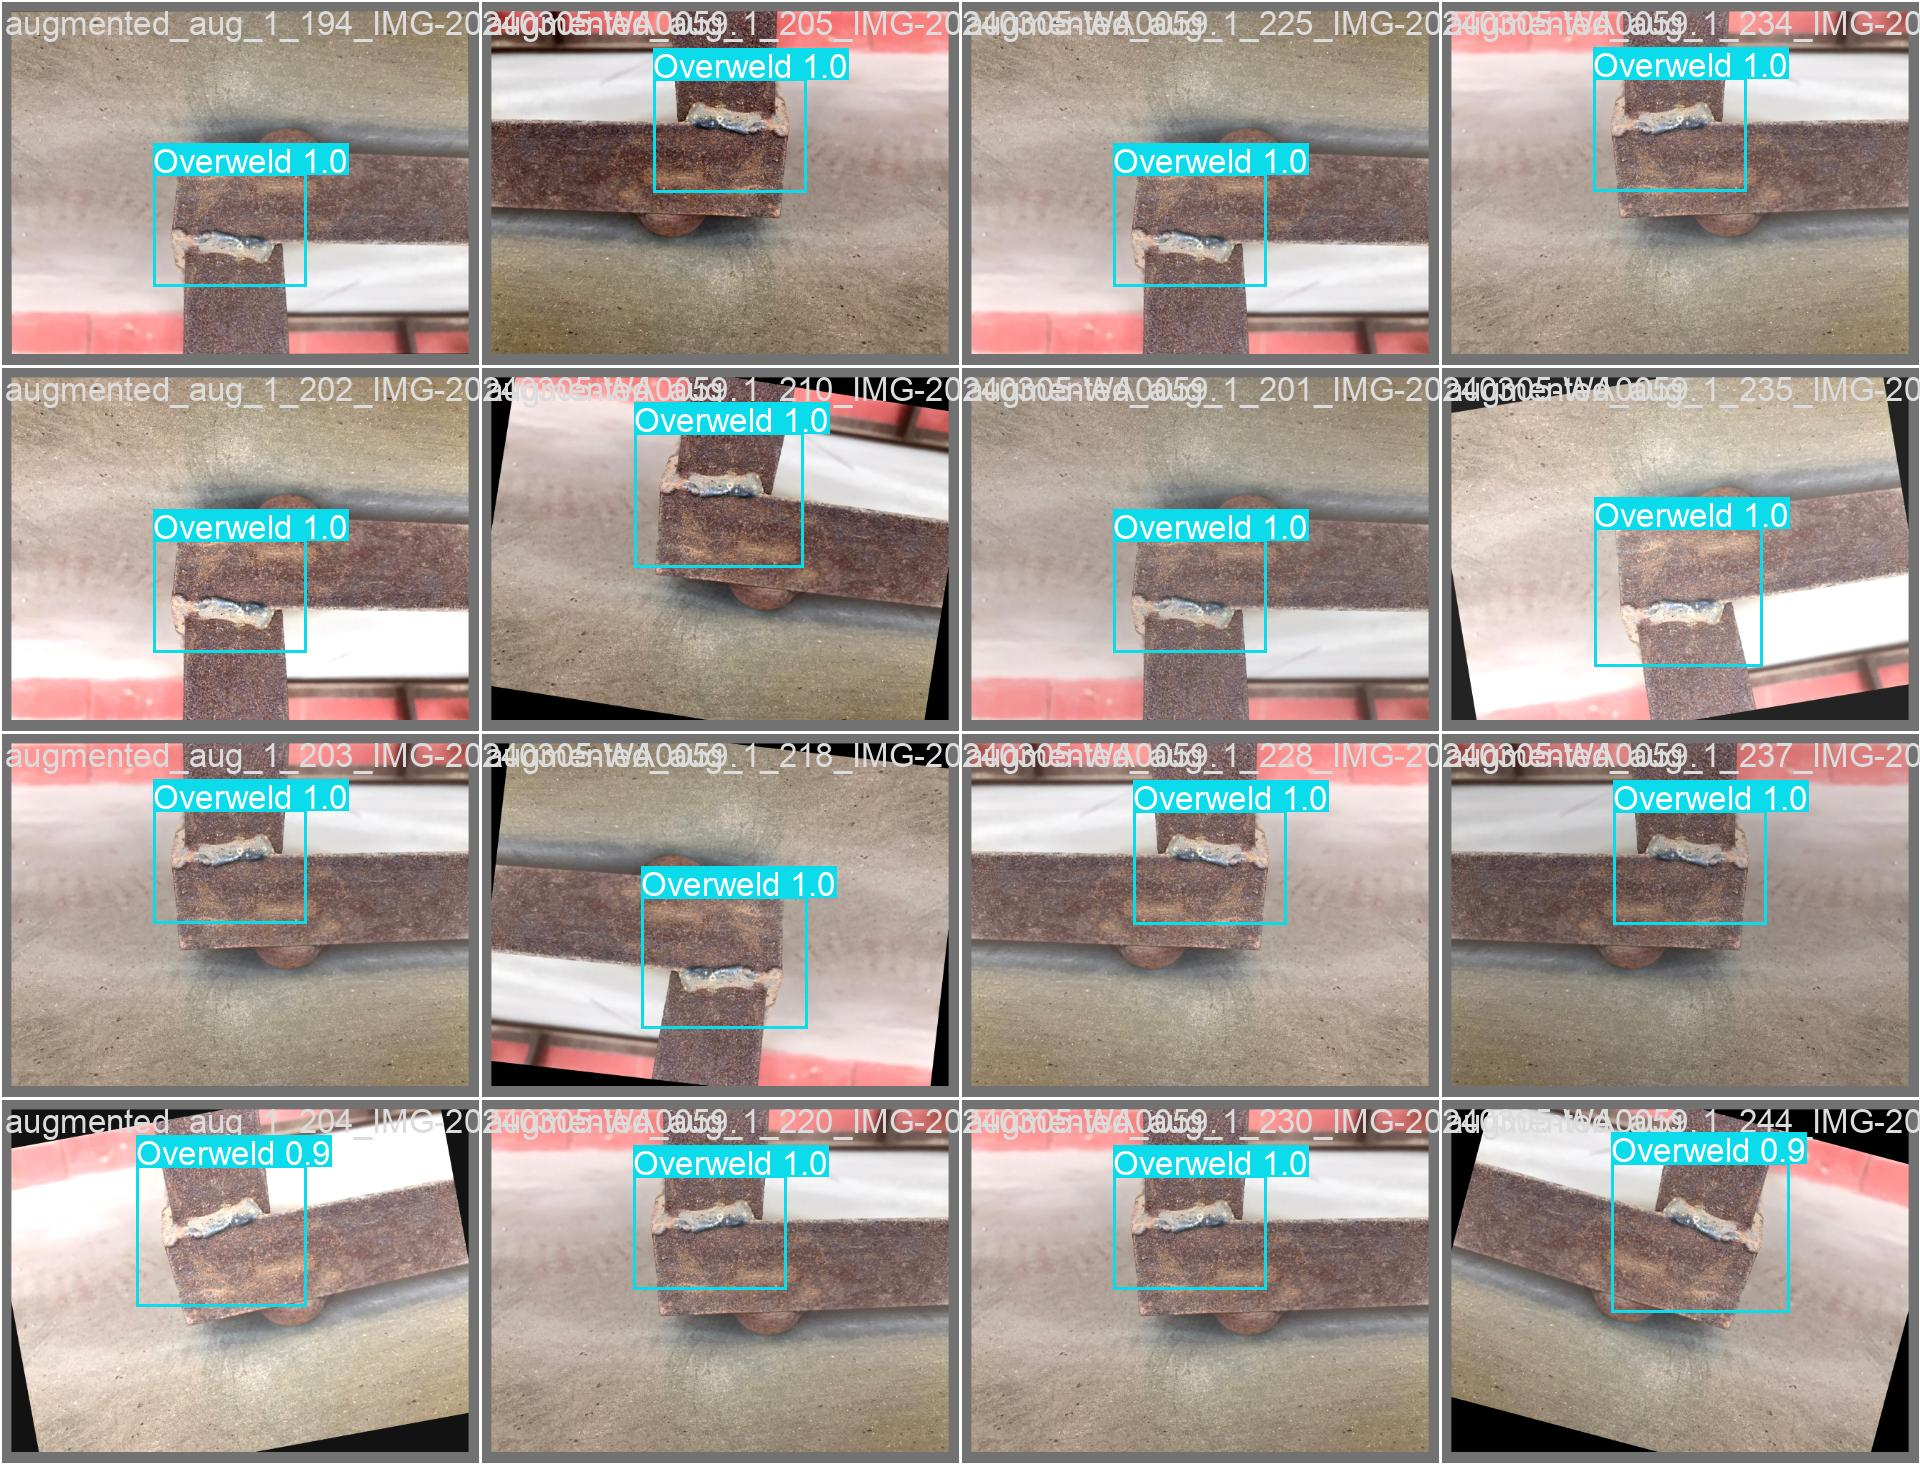

In [27]:
from IPython.display import Image

# Display an image from the evaluation results
eval_image_path = '/content/runs/detect/val/val_batch0_pred.jpg'  # Change to path of an eval image
Image(filename=eval_image_path)


In [ ]:
# Print the evaluation results
# print(results.pandas().xywh)  # This line is causing the error - Remove or comment it
print(results)  # Print the DetMetrics object to see its structure
print(f"mAP@0.5: {results.box.map50}")  # Access mAP@0.5 using results.box.map50
# or print(f"mAP@0.5: {results.box.maps[0.5]}") # using results.box.maps[0.5]

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4158a11f60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!sudo locale-gen en_US.UTF-8
!sudo update-locale LANG=en_US.UTF-8

Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


In [28]:
import shutil

# Specify the folder you want to zip
folder_path = '/content/runs'

# Specify the name of the zip file
zip_filename = 'runs.zip'

# Zip the folder
shutil.make_archive(zip_filename, 'zip', folder_path)

# Download the zip file
from google.colab import files
files.download(zip_filename + '.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Download the best model
files.download('runs/detect/train2/weights/best.pt')
# Download the last model
files.download('runs/detect/train2/weights/last.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Yolov8m

In [7]:
from ultralytics import YOLO
import torch

# Path to your dataset's YAML file
#data_yaml_path = '/content/drive/MyDrive/Defects_welding/yolo/data.yaml'  # Ensure this YAML file is correctly configured

data_yaml_path = "/kaggle/working/data.yaml"
# Load YOLOv8 model with pre-trained weights
model = YOLO("yolov8m.pt")  # Using YOLOv8 weights

# Train the model
model.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 31.1MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 92.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/data-welding/train-20250312T172148Z-001/train/labels... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:06<00:00, 243.13it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/data-welding/train-20250312T172148Z-001/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/data-welding/test-20250312T172147Z-001/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:01<00:00, 246.57it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/data-welding/test-20250312T172147Z-001/test is not writeable, cache not saved.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.66G      1.508      1.887      1.622         31        640: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]

                   all        400        405      0.914      0.886       0.92      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.37G     0.9369      0.727      1.239         34        640: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


                   all        400        405      0.978      0.925      0.954       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.37G     0.8049     0.6215      1.159         36        640: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

                   all        400        405      0.984      0.924      0.959      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.38G     0.6969     0.5362      1.095         30        640: 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

                   all        400        405      0.954      0.922      0.952      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.38G     0.6454     0.5102      1.075         27        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


                   all        400        405      0.991       0.92       0.96      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.38G     0.5812     0.4523      1.025         34        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


                   all        400        405      0.994      0.914      0.965      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.38G      0.543     0.4165      1.009         23        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

                   all        400        405      0.994      0.914      0.964      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.38G      0.527     0.4141     0.9993         27        640: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


                   all        400        405      0.992      0.923      0.968      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.38G     0.4786     0.3713     0.9731         34        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]

                   all        400        405      0.993      0.919      0.967      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.38G     0.4531     0.3474     0.9613         37        640: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

                   all        400        405      0.991       0.92      0.963      0.914


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.38G     0.3684     0.2847     0.9316         16        640: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

                   all        400        405      0.972      0.944      0.975      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.38G     0.3548     0.2776     0.9281         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all        400        405      0.969      0.943      0.974       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.38G     0.3406     0.2594     0.9126         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all        400        405      0.979      0.933      0.978       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.38G     0.3262     0.2515     0.9098         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

                   all        400        405      0.979      0.934      0.976      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.38G     0.3062     0.2353     0.8855         16        640: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]

                   all        400        405      0.972      0.949      0.979      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.38G     0.2766     0.2207     0.8769         16        640: 100%|██████████| 100/100 [00:44<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

                   all        400        405      0.995      0.923      0.978      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.38G     0.2616     0.2038     0.8746         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all        400        405      0.981      0.933      0.975      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.38G     0.2517     0.1988     0.8644         16        640: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]

                   all        400        405      0.976      0.938      0.979      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.38G     0.2319     0.1804     0.8509         16        640: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]

                   all        400        405      0.978      0.935      0.981      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.38G     0.2233     0.1723     0.8567         16        640: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


                   all        400        405      0.971      0.944       0.98       0.95

20 epochs completed in 0.289 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


                   all        400        405      0.978      0.935      0.981      0.951
              Porosity        104        104      0.968      0.952      0.973      0.944
              Overweld        102        103          1      0.892      0.984      0.939
           Underfilled         85         85      0.942      0.953      0.974      0.952
              Undercut        112        113          1      0.943      0.992      0.967


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 9.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78c657192020>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [8]:
# Path to your trained model (change this to the correct path)
model_path = 'runs/detect/train3/weights/best.pt'  # Replace with the correct path to the best model

# Evaluate the model
model = YOLO(model_path)

# Evaluate on the validation dataset (it automatically uses the val split from your YAML file)
results = model.val(data=data_yaml_path)

Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/input/data-welding/test-20250312T172147Z-001/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 908.14it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/data-welding/test-20250312T172147Z-001/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


                   all        400        405      0.978      0.935      0.981       0.95
              Porosity        104        104      0.968      0.952      0.975      0.946
              Overweld        102        103          1      0.892      0.985      0.936
           Underfilled         85         85      0.942      0.953      0.974      0.952
              Undercut        112        113          1      0.943      0.992      0.967


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 18.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val


In [46]:
model = YOLO("/kaggle/input/modelweld/pytorch/default/1/models_ennd-WELDING/kaggle/working/yolov5/runs/detect/train3/weights/best.pt") 
from ultralytics import YOLO
# Run inference on test images
results = model.predict(test_images, save_txt=True, save_conf=True)




image 1/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_0_ml.jpg: 640x480 (no detections), 37.0ms
image 2/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_10_ml.jpg: 640x480 1 Porosity, 27.6ms
image 3/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_11_ml.jpg: 640x480 1 Porosity, 27.6ms
image 4/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_12_ml.jpg: 640x480 1 Porosity, 27.6ms
image 5/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_13_ml.jpg: 640x480 1 Porosity, 27.6ms
image 6/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_14_ml.jpg: 640x480 (no detections), 19.6ms
image 7/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_15_ml.jpg: 640x480 1 Underfilled, 18.6ms
image 8/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images

In [47]:
predictions = load_predictions("runs/detect/predict6/labels")
ground_truth = load_yolo_labels("/kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/labels")

correct = 0
total = 0

for img in ground_truth:
    if img in predictions:
        gt_classes = ground_truth[img]
        pred_classes = predictions[img]
        
        # Consider correct if any prediction matches a ground truth class
        for gt in gt_classes:
            if gt in pred_classes:
                correct += 1
        total += len(gt_classes)

accuracy = (correct / total) * 100
print(f"Classification Accuracy: {accuracy:.2f}%")
# Compute metrics
tp, fp, fn, total_gt = compute_metrics(ground_truth, predictions, num_classes=4)

precision, recall, f1_score, macro_p, macro_r, macro_f1 = calculate_scores(tp, fp, fn, total_gt)

# Print results
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1_score}")
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")

# Compute metrics
macro_p, macro_r, macro_f1, weighted_p, weighted_r, weighted_f1 = compute_overall_metrics(precision, recall, f1_score, total_gt)

# Print results
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")
print(f"Weighted Precision: {weighted_p:.2f}, Weighted Recall: {weighted_r:.2f}, Weighted F1-score: {weighted_f1:.2f}")

Classification Accuracy: 96.06%
Precision per class: {0: 0.9846153846153847, 1: 1.0, 2: 0.8469387755102041, 3: 0.9479166666666666}
Recall per class: {0: 0.64, 1: 0.79, 2: 0.83, 3: 0.91}
F1-score per class: {0: 0.7757575757575756, 1: 0.8826815642458101, 2: 0.8383838383838385, 3: 0.9285714285714285}
Macro Precision: 0.94, Macro Recall: 0.79, Macro F1-score: 0.86
Macro Precision: 0.94, Macro Recall: 0.79, Macro F1-score: 0.86
Weighted Precision: 0.94, Weighted Recall: 0.79, Weighted F1-score: 0.86


## YOLOv8l

In [9]:
from ultralytics import YOLO
import torch

#\
# Load YOLOv8 model with pre-trained weights
model2 = YOLO("yolov8l.pt")  # Using YOLOv8 weights

# Train the model
model2.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

100%|██████████| 83.7M/83.7M [00:00<00:00, 367MB/s]


Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /kaggle/input/data-welding/train-20250312T172148Z-001/train/labels... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:01<00:00, 933.31it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/data-welding/train-20250312T172148Z-001/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/data-welding/test-20250312T172147Z-001/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 480.42it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/data-welding/test-20250312T172147Z-001/test is not writeable, cache not saved.


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.86G       1.38      1.633      1.655         31        640: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]

                   all        400        405      0.765      0.826      0.918       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.77G     0.8795     0.7344       1.22         34        640: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]

                   all        400        405      0.943      0.854      0.903      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.78G      0.775     0.6557       1.14         36        640: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        405      0.843      0.902      0.905      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.79G     0.6812     0.5495      1.082         30        640: 100%|██████████| 100/100 [01:14<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]

                   all        400        405       0.91      0.918      0.932      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.79G     0.6355     0.5022      1.065         27        640: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]

                   all        400        405      0.983      0.916      0.948      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.79G     0.5782     0.4628       1.03         34        640: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]

                   all        400        405      0.992      0.916       0.96      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.79G     0.5226     0.4148          1         23        640: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]

                   all        400        405      0.986      0.921      0.969      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.79G     0.5069     0.4002      0.991         27        640: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]

                   all        400        405      0.993      0.923      0.963      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.79G     0.4799     0.3743     0.9751         34        640: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        405      0.994      0.918       0.96      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.79G     0.4588     0.3572     0.9618         37        640: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]

                   all        400        405       0.99      0.928      0.971       0.91


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.79G     0.3698     0.2942     0.9282         16        640: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]

                   all        400        405       0.98      0.942      0.974      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.79G     0.3527     0.2811     0.9198         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]

                   all        400        405      0.992      0.924      0.972       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.79G     0.3354      0.263     0.9107         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        405      0.997      0.916      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.79G     0.3183     0.2544      0.897         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        405       0.99      0.921      0.975       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.79G     0.3049     0.2415     0.8851         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        405      0.978      0.938      0.973       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.79G     0.2755     0.2206      0.874         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]

                   all        400        405      0.989      0.923      0.979      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.79G     0.2659     0.2105     0.8772         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]

                   all        400        405      0.987      0.924      0.978      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.79G     0.2432     0.1918     0.8589         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        405       0.98      0.934      0.981      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.79G      0.228     0.1775     0.8479         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        405      0.965      0.947       0.98       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.79G     0.2218     0.1717     0.8535         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]

                   all        400        405      0.975       0.94      0.979      0.947



20 epochs completed in 0.445 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 87.6MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


                   all        400        405      0.965      0.947      0.981       0.95
              Porosity        104        104       0.98      0.942      0.974      0.946
              Overweld        102        103      0.994      0.903      0.982      0.931
           Underfilled         85         85      0.906      0.976      0.974      0.958
              Undercut        112        113      0.982      0.964      0.991      0.966


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 13.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78c655e26770>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [10]:
# Path to your trained model (change this to the correct path)
model_path = 'runs/detect/train4/weights/best.pt'  # Replace with the correct path to the best model

# Evaluate the model
model2 = YOLO(model_path)

# Evaluate on the validation dataset (it automatically uses the val split from your YAML file)
results = model2.val(data=data_yaml_path)

Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /kaggle/input/data-welding/test-20250312T172147Z-001/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 904.17it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/data-welding/test-20250312T172147Z-001/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


                   all        400        405      0.965      0.947      0.982       0.95
              Porosity        104        104       0.98      0.942      0.974      0.946
              Overweld        102        103      0.993      0.903      0.987      0.931
           Underfilled         85         85      0.906      0.976      0.974      0.958
              Undercut        112        113      0.982      0.964      0.992      0.965


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.8ms preprocess, 29.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val2


In [48]:
model = YOLO("/kaggle/input/modelweld/pytorch/default/1/models_ennd-WELDING/kaggle/working/yolov5/runs/detect/train4/weights/best.pt") 
from ultralytics import YOLO
# Run inference on test images
results = model.predict(test_images, save_txt=True, save_conf=True)




image 1/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_0_ml.jpg: 640x480 (no detections), 48.6ms
image 2/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_10_ml.jpg: 640x480 1 Porosity, 36.6ms
image 3/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_11_ml.jpg: 640x480 1 Porosity, 33.3ms
image 4/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_12_ml.jpg: 640x480 1 Porosity, 33.3ms
image 5/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_13_ml.jpg: 640x480 1 Porosity, 33.3ms
image 6/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_14_ml.jpg: 640x480 (no detections), 29.7ms
image 7/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_15_ml.jpg: 640x480 1 Underfilled, 26.1ms
image 8/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images

In [49]:
predictions = load_predictions("runs/detect/predict7/labels")
ground_truth = load_yolo_labels("/kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/labels")

correct = 0
total = 0

for img in ground_truth:
    if img in predictions:
        gt_classes = ground_truth[img]
        pred_classes = predictions[img]
        
        # Consider correct if any prediction matches a ground truth class
        for gt in gt_classes:
            if gt in pred_classes:
                correct += 1
        total += len(gt_classes)

accuracy = (correct / total) * 100
print(f"Classification Accuracy: {accuracy:.2f}%")
# Compute metrics

Classification Accuracy: 96.83%


In [50]:
tp, fp, fn, total_gt = compute_metrics(ground_truth, predictions, num_classes=4)

precision, recall, f1_score, macro_p, macro_r, macro_f1 = calculate_scores(tp, fp, fn, total_gt)

# Print results
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1_score}")
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")

# Compute metrics
macro_p, macro_r, macro_f1, weighted_p, weighted_r, weighted_f1 = compute_overall_metrics(precision, recall, f1_score, total_gt)

# Print results
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")
print(f"Weighted Precision: {weighted_p:.2f}, Weighted Recall: {weighted_r:.2f}, Weighted F1-score: {weighted_f1:.2f}")

Precision per class: {0: 0.984375, 1: 0.9534883720930233, 2: 0.9156626506024096, 3: 0.9767441860465116}
Recall per class: {0: 0.63, 1: 0.82, 2: 0.76, 3: 0.84}
F1-score per class: {0: 0.7682926829268293, 1: 0.8817204301075269, 2: 0.8306010928961748, 3: 0.9032258064516129}
Macro Precision: 0.96, Macro Recall: 0.76, Macro F1-score: 0.85
Macro Precision: 0.96, Macro Recall: 0.76, Macro F1-score: 0.85
Weighted Precision: 0.96, Weighted Recall: 0.76, Weighted F1-score: 0.85


## Yolov8n

In [5]:
from ultralytics import YOLO
import torch

# Path to your dataset's YAML file
data_yaml_path = '/kaggle/working/data.yaml'  # Ensure this YAML file is correctly configured

# Load YOLOv8 model with pre-trained weights
model3 = YOLO("yolov8n.pt")  # Using YOLOv8 weights

# Train the model
model3.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, m

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/data-welding/train-20250312T172148Z-001/train/labels... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:07<00:00, 210.40it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/data-welding/train-20250312T172148Z-001/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/data-welding/test-20250312T172147Z-001/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:01<00:00, 204.30it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/data-welding/test-20250312T172147Z-001/test is not writeable, cache not saved.


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.55G      1.682      2.561      1.927         31        640: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]

                   all        400        405      0.547      0.906       0.78      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.11G      1.129      1.105      1.471         34        640: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]

                   all        400        405      0.981       0.92      0.948      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.12G     0.9642     0.9226      1.336         36        640: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]

                   all        400        405      0.957      0.917      0.949      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.12G     0.8468     0.7621      1.249         30        640: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


                   all        400        405      0.968      0.928      0.957      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.12G     0.7755     0.6891      1.194         27        640: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.68it/s]

                   all        400        405      0.985      0.925      0.964      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.12G      0.712     0.6195      1.139         34        640: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]

                   all        400        405      0.982      0.929      0.962      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.12G     0.6869     0.5775      1.122         23        640: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]

                   all        400        405      0.982      0.934      0.974      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.12G     0.6609     0.5666      1.108         27        640: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.80it/s]

                   all        400        405      0.984      0.935       0.97       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.12G     0.5967     0.5035      1.069         34        640: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]

                   all        400        405      0.981      0.937      0.974      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.12G     0.5823     0.4877      1.055         37        640: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]

                   all        400        405      0.994      0.924      0.972      0.884


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.12G     0.4805     0.4182      1.008         16        640: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.76it/s]

                   all        400        405       0.98       0.94      0.974      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.12G      0.439     0.3827     0.9862         16        640: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]

                   all        400        405       0.99      0.924      0.971      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.12G     0.4064     0.3648       0.96         16        640: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]

                   all        400        405      0.979      0.951      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.12G     0.3924     0.3429     0.9567         16        640: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.67it/s]

                   all        400        405      0.984      0.952      0.976      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.12G     0.3837     0.3252     0.9439         16        640: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.71it/s]

                   all        400        405      0.976      0.947      0.975      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.12G     0.3348     0.3103     0.9154         16        640: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]

                   all        400        405      0.984      0.948       0.98      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.12G     0.3178     0.2945     0.9058         16        640: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]

                   all        400        405      0.968       0.96      0.983      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.12G     0.3071     0.2795      0.902         16        640: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.73it/s]

                   all        400        405      0.972      0.959      0.983      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.12G     0.2902     0.2623     0.8854         16        640: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]

                   all        400        405      0.973      0.958      0.983      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.12G     0.2812     0.2563     0.8873         16        640: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]

                   all        400        405      0.973       0.96      0.983      0.948



20 epochs completed in 0.122 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.2MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


                   all        400        405      0.973      0.958      0.983      0.947
              Porosity        104        104      0.981      0.962      0.986      0.949
              Overweld        102        103       0.99       0.95      0.978      0.927
           Underfilled         85         85      0.946      0.953      0.975      0.949
              Undercut        112        113      0.973      0.968      0.992      0.962


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ea34d1237c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [26]:
# Path to your trained model (change this to the correct path)
from ultralytics import YOLO
model_path = '/kaggle/input/modelweld/pytorch/default/1/models_ennd-WELDING/kaggle/working/yolov5/runs/detect/train6/weights/best.pt'  # Replace with the correct path to the best model

# Evaluate the model
model3 = YOLO(model_path)

# Evaluate on the validation dataset (it automatically uses the val split from your YAML file)
results = model3.val(data="/kaggle/working/data.yaml")

Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/data-welding/test-20250312T172147Z-001/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 789.10it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/data-welding/test-20250312T172147Z-001/test is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.48it/s]


                   all        400        405      0.975      0.955      0.982      0.947
              Porosity        104        104      0.981      0.962      0.985      0.948
              Overweld        102        103          1      0.939      0.979      0.925
           Underfilled         85         85      0.945      0.953      0.976      0.953
              Undercut        112        113      0.973      0.968      0.991      0.963


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 2.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val3


In [27]:
model = YOLO("/kaggle/input/modelweld/pytorch/default/1/models_ennd-WELDING/kaggle/working/yolov5/runs/detect/train6/weights/best.pt") 
from ultralytics import YOLO
# Run inference on test images
results = model.predict(test_images, save_txt=True, save_conf=True)


image 1/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_0_ml.jpg: 640x480 (no detections), 7.9ms
image 2/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_10_ml.jpg: 640x480 1 Porosity, 6.6ms
image 3/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_11_ml.jpg: 640x480 1 Porosity, 6.4ms
image 4/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_12_ml.jpg: 640x480 1 Porosity, 6.4ms
image 5/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_13_ml.jpg: 640x480 1 Porosity, 6.4ms
image 6/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_14_ml.jpg: 640x480 (no detections), 6.3ms
image 7/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_0_15_ml.jpg: 640x480 (no detections), 6.7ms
image 8/400 /kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/images/aug_

In [46]:
predictions = load_predictions("runs/detect/predict3/labels")
ground_truth = load_yolo_labels("/kaggle/input/data-welding/Testdata-20250320T164930Z-001/Testdata/labels")

correct = 0
total = 0

for img in ground_truth:
    if img in predictions:
        gt_classes = ground_truth[img]
        pred_classes = predictions[img]
        
        # Consider correct if any prediction matches a ground truth class
        for gt in gt_classes:
            if gt in pred_classes:
                correct += 1
        total = 320

accuracy = (correct / total) * 100
print(f"Classification Accuracy: {accuracy:.2f}%")

Classification Accuracy: 94.69%


In [20]:
tp, fp, fn, total_gt = compute_metrics(ground_truth, predictions, num_classes=4)

precision, recall, f1_score, macro_p, macro_r, macro_f1 = calculate_scores(tp, fp, fn, total_gt)

# Print results
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1_score}")
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")

# Compute metrics
macro_p, macro_r, macro_f1, weighted_p, weighted_r, weighted_f1 = compute_overall_metrics(precision, recall, f1_score, total_gt)

# Print results
print(f"Macro Precision: {macro_p:.2f}, Macro Recall: {macro_r:.2f}, Macro F1-score: {macro_f1:.2f}")
print(f"Weighted Precision: {weighted_p:.2f}, Weighted Recall: {weighted_r:.2f}, Weighted F1-score: {weighted_f1:.2f}")

Precision per class: {0: 1.0, 1: 0.9761904761904762, 2: 1.0, 3: 0.9880952380952381}
Recall per class: {0: 0.63, 1: 0.82, 2: 0.75, 3: 0.83}
F1-score per class: {0: 0.7730061349693252, 1: 0.8913043478260869, 2: 0.8571428571428571, 3: 0.9021739130434783}
Macro Precision: 0.99, Macro Recall: 0.76, Macro F1-score: 0.86
Macro Precision: 0.99, Macro Recall: 0.76, Macro F1-score: 0.86
Weighted Precision: 0.99, Weighted Recall: 0.76, Weighted F1-score: 0.86


In [1]:
!zip -r /kaggle/working/models_ennd.zip /kaggle/working/yolov5/runs

  adding: kaggle/working/yolov5/runs/ (stored 0%)
  adding: kaggle/working/yolov5/runs/detect/ (stored 0%)
  adding: kaggle/working/yolov5/runs/detect/train10/ (stored 0%)
  adding: kaggle/working/yolov5/runs/detect/train10/val_batch1_pred.jpg (deflated 8%)
  adding: kaggle/working/yolov5/runs/detect/train10/train_batch0.jpg (deflated 3%)
  adding: kaggle/working/yolov5/runs/detect/train10/val_batch0_pred.jpg (deflated 8%)
  adding: kaggle/working/yolov5/runs/detect/train10/F1_curve.png (deflated 12%)
  adding: kaggle/working/yolov5/runs/detect/train10/train_batch2.jpg (deflated 3%)
  adding: kaggle/working/yolov5/runs/detect/train10/labels_correlogram.jpg (deflated 51%)
  adding: kaggle/working/yolov5/runs/detect/train10/PR_curve.png (deflated 18%)
  adding: kaggle/working/yolov5/runs/detect/train10/train_batch1002.jpg (deflated 7%)
  adding: kaggle/working/yolov5/runs/detect/train10/args.yaml (deflated 52%)
  adding: kaggle/working/yolov5/runs/detect/train10/val_batch2_pred.jpg (defl